# P1 MyAutoPano

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [119]:
# Visualisation functions
def show_image(img, title="Image"):
    """
    Displays an image using matplotlib.
    
    Parameters:
    -----------
    img : np.ndarray
        The image array (grayscale or color).
    title : str, optional
        Title for the plot.
    """

    # Convert image to numpy array (in case it's not)
    img = np.array(img)

    plt.figure(figsize=(12, 12))
    plt.title(title)
    plt.axis('off')

    # If the image has 3 channels, assume it's color (RGB or BGR)
    if len(img.shape) == 3:
        # If it's BGR (as from OpenCV), convert to RGB
        if img.shape[2] == 3:
            img = img[..., ::-1]  # flip color channels
        plt.imshow(img)
    else:
        # Grayscale image
        plt.imshow(img, cmap='gray')

    plt.show()

def show_filter_bank(filters, r, c, figsize=(12, 8), cmap='gray', titles=None):
    """
    Display a list of filters in a grid of r rows and c columns.
    Supports both grayscale and color filters.

    Parameters:
        filters (list of arrays): Filters to display (2D or 3D arrays)
        r (int): Number of rows
        c (int): Number of columns
        figsize (tuple): Figure size
        cmap (str): Colormap for grayscale images
        titles (list of str): Optional titles for each filter
    """
    n = len(filters)
    plt.figure(figsize=figsize)
    
    for i in range(r*c):
        plt.subplot(r, c, i+1)
        if i < n:
            f = filters[i]
            # If grayscale, use cmap; if color, no cmap
            if f.ndim == 2:
                plt.imshow(f, cmap=cmap)
            elif f.ndim == 3 and f.shape[2] in [3, 4]:  # RGB or RGBA
                # Convert BGR to RGB for proper display
                f_rgb = cv2.cvtColor(f, cv2.COLOR_BGR2RGB) if f.shape[2] == 3 else f
                plt.imshow(f_rgb)
            else:
                # fallback for unexpected shapes
                plt.imshow(f, cmap=cmap)
            plt.axis('off')
            if titles:
                plt.title(titles[i], fontsize=10)
        else:
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def show_side_by_side(image1,  image2, title= "", figsize=(10, 6)):
    titles = ["Before "+ title, "After " + title]
    bank = [image1, image2]
    show_filter_bank(bank, 1, 2, figsize, None ,titles)

def draw_corners(img,  corners):
    c_img = img.copy()
    if corners is not None:
        for corner in corners:
            x, y = corner.ravel()  # Flatten the array
            cv2.circle(c_img, (int(x), int(y)), 3, (0, 0, 255), -1)

    return c_img


         


##### Corner Detection

In [106]:
def corner_detection(img, to_detect):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, to_detect, 0.01, 10)

    return corners

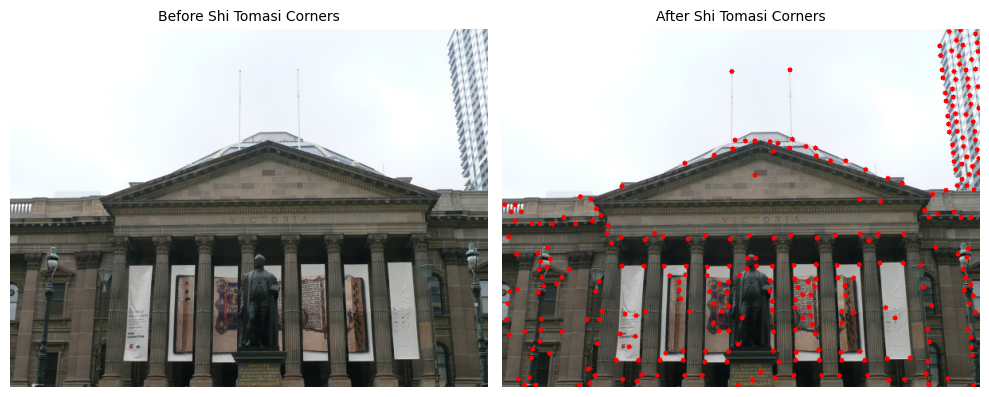

In [ ]:
# Read image
img = cv2.imread(r"F:\CV\RBE549\Nehal_p1/Phase1/Data/Train/Set1/1.jpg")


# Detect Features
to_detect=300

corners = corner_detection(img, to_detect)
img_shi = draw_corners(img, corners)
show_side_by_side(img, img_shi, "Shi Tomasi Corners")

#### ANMS


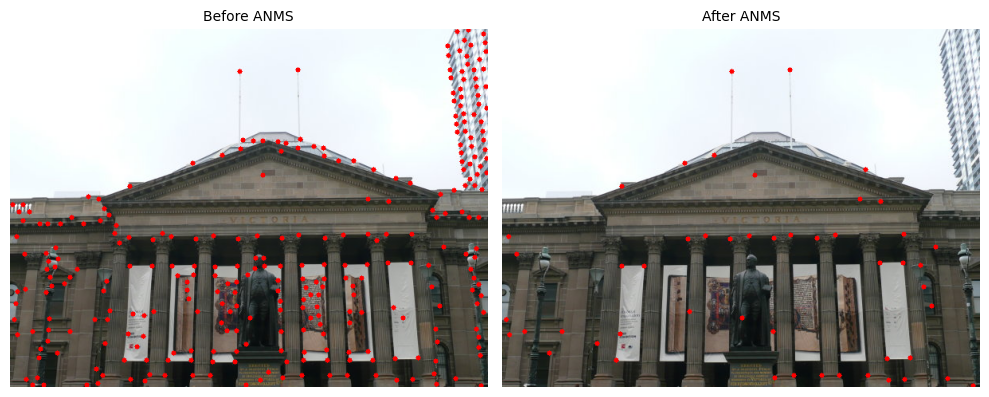

In [104]:
# Find all corners
# For all corners find a corner closest to it
# Rank corners by descending order of distance of the closest corner
# Select first N corners, they are the ones most spreadout as their neighbours are the furthest

# Vectorized anms
def anms(corners, corners_wanted):
    corners = corners.reshape((-1, 2))                      # Make sure shape is (N,2)
    num_corners = corners.shape[0]
    distance_to_closest = np.empty(num_corners)

    corners_x = corners[:,0].reshape(-1,1)
    corners_y = corners[:,1].reshape(-1,1)
    # print("corners_x, corners_y- ", corners_x.shape, corners_y.shape)

    Dx = corners_x - corners_x.T                            # Get arrays of N by N with substractions done per pair
    Dy = corners_y - corners_y.T 
    # print("Dx, Dy- ", Dx.shape, Dy.shape)

    D2 = Dx**2 + Dy**2                                        # Get distance squared per pair by inplace squaring and addition
    # print("D2", D2.shape)

    mask = ~np.eye(num_corners, dtype=bool)
    D2_no_self = np.where(mask, D2, np.nan)
    d_closest = np.nanmin(D2_no_self, axis=1)               # per row

    top_indices = np.argsort(d_closest)[-corners_wanted:]   # get from end corners_wanted ascending 
    top_indices = top_indices[::-1]                         # make it descending
    top_corners = corners[top_indices]

    return top_corners

corners_anms = anms(corners, 50)
img_anms = draw_corners(img, corners_anms)
show_side_by_side(img_shi, img_anms, title = "ANMS")

#### Feature Descriptor

In [105]:
# Very simple feature descriptor
# x is horizontal, y is vertical
def get_features(img, corners):
    size_patch = 41

    shift = size_patch//2
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray= cv2.GaussianBlur(gray, (5,5), 1)
    img_updated = cv2.copyMakeBorder(gray, shift, shift, shift,  shift,  cv2.BORDER_REPLICATE)

    # features  = np.empty((len(corners), 8,8))
    features  = np.empty((len(corners), 64))
    for corner_i, corner in enumerate(corners):
        x, y = corner
        x,  y = int(x) +shift, int(y)+shift
        patch = img_updated[y-shift:y+shift:5, x-shift:x+shift:5]
        features[corner_i] = patch.reshape(1,64)
        # features[corner_i] = patch

    return features

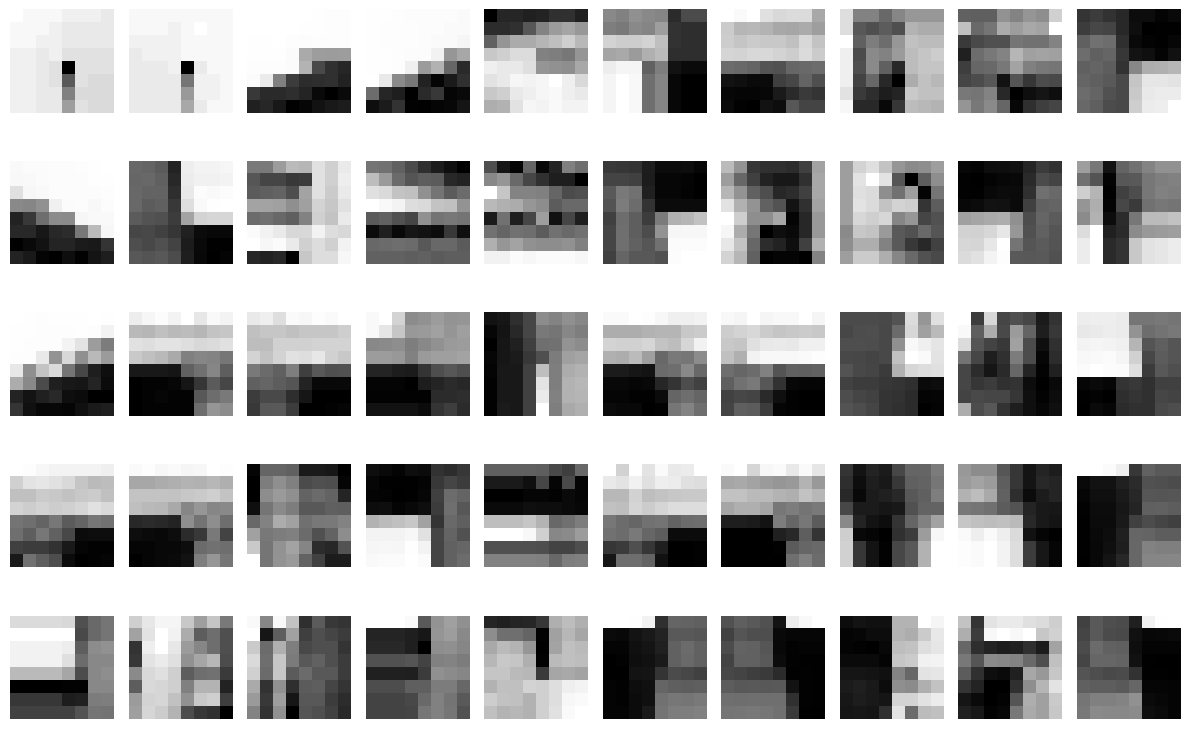

In [ ]:
# Visuavalised features - uncomment commented and comment uncommented

features = get_features(img, corners_anms)
show_filter_bank(features, 5, 10)

#### Feature Matching

In [ ]:
# Vectorized
def match_features(features1,  features2):
    N, feature_lenght = features1.shape

    features1 = features1.reshape((N,1,feature_lenght))
    features2 = features2.reshape((1,N,feature_lenght))

    dist_per_axis = features1 - features2
    # print(dist_per_axis.shape)
    # print(dist[:,:,0])
    D2 =  np.sum(dist_per_axis**2, axis=2)
    # print("D2- ", D2.shape)

    d_closest = np.argmin(D2, axis =1)                      # per row that is get closest feature index for feature1
    # print(d_closest.shape)

    return d_closest

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

### Checking Feature Matching

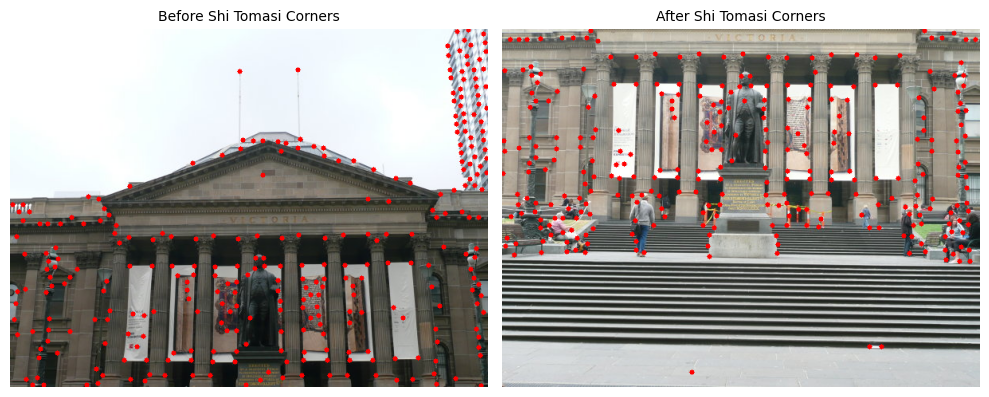

In [129]:
# CORNER DETECTION

to_detect=300

img1 = cv2.imread(r"F:\CV\RBE549\Nehal_p1/Phase1/Data/Train/Set1/1.jpg")
img2 = cv2.imread(r"F:\CV\RBE549\Nehal_p1/Phase1/Data/Train/Set1/2.jpg")

corners1 = corner_detection(img1, to_detect)
corners2 = corner_detection(img2, to_detect)

# Visualise
img_shi1 = draw_corners(img1, corners1)
img_shi2 = draw_corners(img2, corners2)
show_side_by_side(img_shi1, img_shi2, "Shi Tomasi Corners")

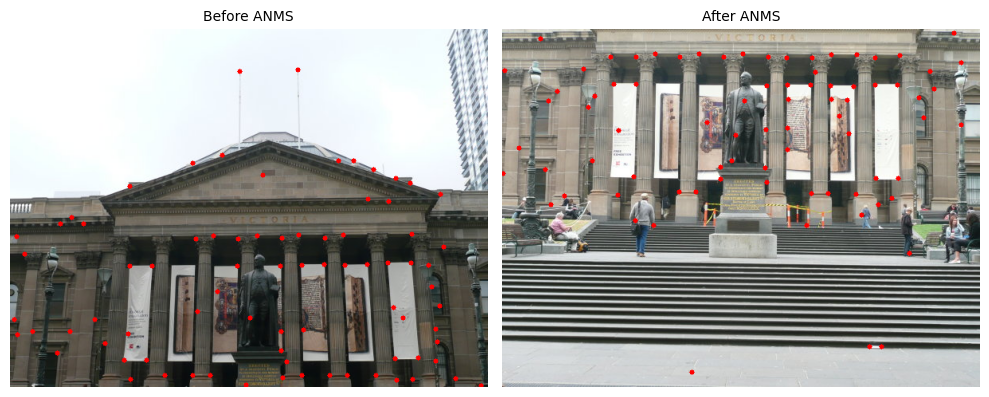

In [133]:
# ANMS
top = 80
corners_anms1 = anms(corners1, top)
corners_anms2 = anms(corners2, top)
img_anms1 = draw_corners(img1, corners_anms1)
img_anms2 = draw_corners(img2, corners_anms2)
show_side_by_side(img_anms1, img_anms2, title = "ANMS")

In [134]:
# Feature Descriptors

features1 = get_features(img1, corners_anms1)
features2 = get_features(img2, corners_anms2)

feature1_mappings  = match_features(features1, features2)       # Get index of feature2 features matching feature1 index
# print(feature1_mappings)

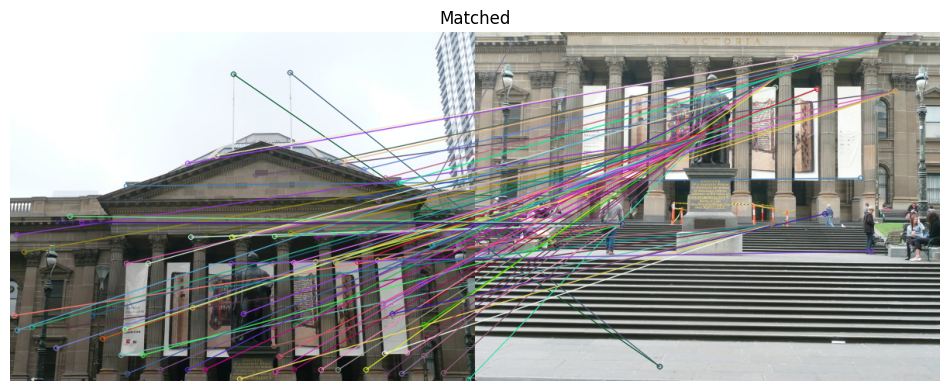

In [137]:

def coords_to_keypoints(corners):
    """
    Convert Nx2 array of corners to a list of cv2.KeyPoint objects.
    
    Parameters:
        corners (np.ndarray): Nx2 array of corner coordinates (x, y)
        
    Returns:
        keypoints (list of cv2.KeyPoint)
    """
    keypoints = [cv2.KeyPoint(float(x), float(y), 1) for x, y in corners]
    return keypoints

def convert_to_matches(feature_mappings):
    matches_manual = []
    for i, j in enumerate(feature_mappings):
        matches_manual.append(cv2.DMatch(_queryIdx=i, _trainIdx=j, _imgIdx=0, _distance=0))
    return  matches_manual

def convert_to_coords(keypoints):
    coords = np.array([kp.pt for kp in keypoints], dtype= np.int32)
    return coords

keypoints1 = coords_to_keypoints(corners_anms1)
keypoints2 = coords_to_keypoints(corners_anms2)
matches = convert_to_matches(feature1_mappings)

img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show_image(img_matches, "Matched")


### New feature descriptor

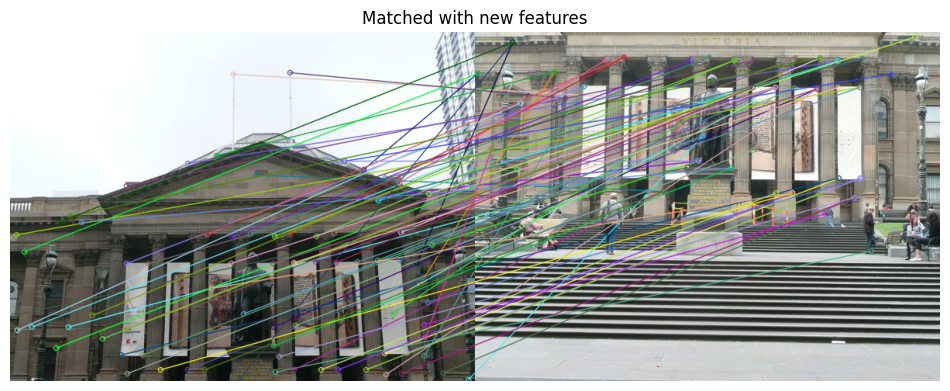

In [139]:
corners_anms1 = anms(corners1, top)
corners_anms2 = anms(corners2, top)

keypoint_anms1 = coords_to_keypoints(corners_anms1)
keypoint_anms2 = coords_to_keypoints(corners_anms2)

sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.compute(img1, keypoint_anms1)
keypoints2, descriptors2 = sift.compute(img2, keypoint_anms2)

coords1 = convert_to_coords(keypoints1)
coords2 = convert_to_coords(keypoints2)

feature1_mappings = match_features(descriptors1, descriptors2)
matches = convert_to_matches(feature1_mappings)

img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show_image(img_matches, "Matched with new features")

## RANSAC Homography

In [174]:
def compute_H(coords1, coords2, feature_mappings, num_iterations, threshold):

    N = len(coords1)
    pts1_all = np.hstack([coords1, np.ones((N,1))]).astype(np.float32)
    pts2_all  = np.hstack([coords2[feature_mappings], np.ones((N,1))]).astype(np.float32)

    inliers = 0
    Hbest=np.empty((3,3))
    for iterations in range(num_iterations):
        point_indices = np.random.choice(N, size=4, replace=False)
        points1 = pts1_all[point_indices,:2]
        points2 = pts2_all[point_indices,:2]
        # print("Points1, Points2: ",  points1, points2)

        H= cv2.getPerspectiveTransform(points1, points2)
        proj_pts1 = (H @ pts1_all.T).T
        d = np.linalg.norm(pts2_all[:,:2]/pts2_all[:,2:3] -  proj_pts1[:,:2]/proj_pts1[:,2:3], axis=1)
        inliers_temp = np.sum(d<threshold)
        if inliers < inliers_temp:
            Hbest = H
            inliers = inliers_temp
    
    return Hbest,  inliers

C:\Users\91744\AppData\Local\Temp\ipykernel_17464\692034712.py:17: RuntimeWarning: divide by zero encountered in divide
  d = np.linalg.norm(pts2_all[:,:2]/pts2_all[:,2:3] -  proj_pts1[:,:2]/proj_pts1[:,2:3], axis=1)
C:\Users\91744\AppData\Local\Temp\ipykernel_17464\692034712.py:17: RuntimeWarning: invalid value encountered in divide
  d = np.linalg.norm(pts2_all[:,:2]/pts2_all[:,2:3] -  proj_pts1[:,:2]/proj_pts1[:,2:3], axis=1)


H-  [[ 1.27822159e+00  1.93758154e-01 -8.30623124e+01]
 [ 2.64017723e-02  1.30982576e+00 -3.10215962e+02]
 [ 1.00902491e-04  6.63741856e-04  1.00000000e+00]]
inliers-  24


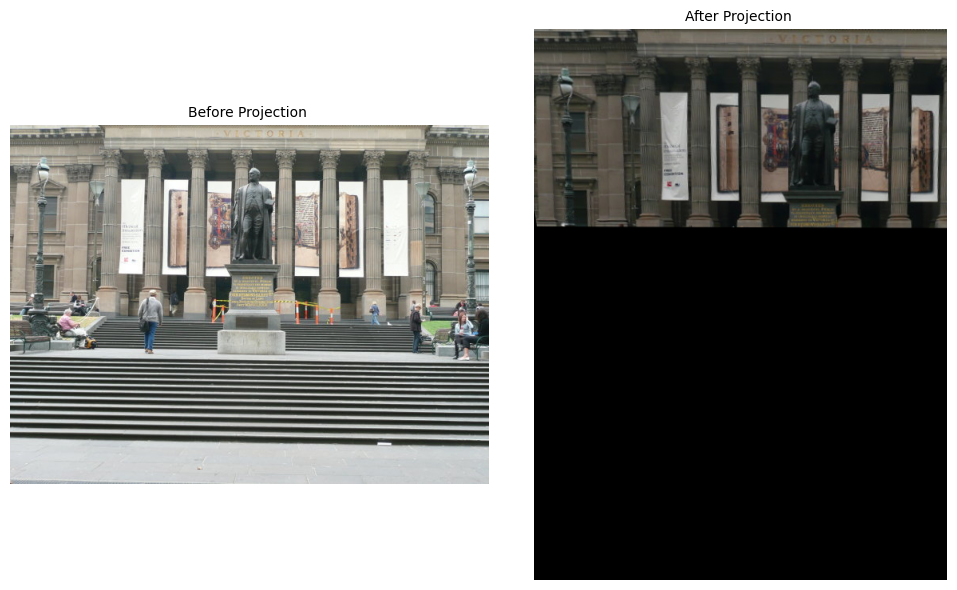

In [181]:
H, inliers= compute_H(coords1, coords2, feature1_mappings,  100000, 20)
print("H- ", H)
print("inliers- ", inliers)

projected_img1 = cv2.warpPerspective(img1, H, img1.shape[:2])
show_side_by_side(img2, projected_img1, "Projection ")